In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

In [230]:
df_true = pd.read_csv('True.csv')

In [231]:
df_true['label'] = 1

In [232]:
df_true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [233]:
df_fake = pd.read_csv('Fake.csv')

In [234]:
df_fake['label'] = 0

In [235]:
df_fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [236]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [237]:
df_true.shape, df_fake.shape

((21417, 5), (23481, 5))

In [238]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [239]:
df_fake.describe()

,label
count,23481.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [240]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/adii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [241]:
stopwords = stopwords.words('english')

In [242]:
stopwords = np.asarray(stopwords)

In [243]:
stopwords.shape

(198,)

In [244]:
df_all = pd.concat([df_true, df_fake], axis=0)

In [245]:
df = df_all.sample(frac=1, random_state=42).reset_index(drop=True)

In [246]:
df.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [247]:
df.shape

(44898, 5)

In [248]:
df['subject'].value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [249]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [250]:
df['content'] = df['title'] + " " + df['text']

In [251]:
df.head()

,title,text,subject,date,label,content
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0,BREAKING: GOP Chairman Grassley Has Had Enoug...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0,Failed GOP Candidates Remembered In Hilarious...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1,California AG pledges to defend birth control ...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,AZ RANCHERS Living On US-Mexico Border Destroy...


In [252]:
X = df.drop(['label', 'date'], axis=1)
y = df['label']

In [253]:
X.head()

,title,text,subject,content
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,BREAKING: GOP Chairman Grassley Has Had Enoug...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,Failed GOP Candidates Remembered In Hilarious...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,California AG pledges to defend birth control ...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,AZ RANCHERS Living On US-Mexico Border Destroy...


*Stemming*
- Stemming is the process of reducing a word to its root word
- eg : actor, actress, acting -> act

In [254]:
port_stem = PorterStemmer()

In [255]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [256]:
df['content'] = df['content'].apply(stemming)

In [257]:
df.head()

,title,text,subject,date,label,content
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0,break gop chairman grassley enough demand trum...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0,fail gop candid rememb hilari mock eulog video...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0,mike penc new dc neighbor hilari troll homopho...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1,california ag pledg defend birth control insur...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,az rancher live us mexico border destroy nanci...


- Combining the subjects whic are similar looking.

In [258]:
df.replace({'subject': {'politicsNews': 'politics', 'worldnews': 'world', 'News': 'news'}}, inplace=True)

In [259]:
df.head()

,title,text,subject,date,label,content
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",news,"July 21, 2017",0,break gop chairman grassley enough demand trum...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,news,"May 7, 2016",0,fail gop candid rememb hilari mock eulog video...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,news,"December 3, 2016",0,mike penc new dc neighbor hilari troll homopho...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politics,"October 6, 2017",1,california ag pledg defend birth control insur...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,az rancher live us mexico border destroy nanci...


In [260]:
# One Hot encoder
ohe = OneHotEncoder()
subject_encoded = ohe.fit_transform(df[['subject']])

In [261]:
df.head()

,title,text,subject,date,label,content
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",news,"July 21, 2017",0,break gop chairman grassley enough demand trum...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,news,"May 7, 2016",0,fail gop candid rememb hilari mock eulog video...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,news,"December 3, 2016",0,mike penc new dc neighbor hilari troll homopho...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politics,"October 6, 2017",1,california ag pledg defend birth control insur...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,az rancher live us mexico border destroy nanci...


In [262]:
X = df[['content', 'subject']]

In [263]:
print(X['content'][0])

break gop chairman grassley enough demand trump jr testimoni donald trump white hous chao tri cover russia problem mount hour refus acknowledg problem surround fake news hoax howev fact bear thing differ seem crack congression public leadership chuck grassley r iowa head senat judiciari committe fed demand donald trump jr former trump campaign manag paul manafort testifi committe regard infam shadi meet donald trump shadi russian lawyer promis dirt democrat presidenti nomine hillari clinton fact inform due well demand send signal team trump notabl fire special counsel robert mueller circumst despit fact seem seem trump white hous lay groundwork speak speak tweet regard grassley warn also anyon think senat grassley rest senat seriou need look warn alreadi given trump jr manafort either follow order serv subpoena forc compli refus held contempt congress carri seriou jail time even cruel craven creatur within gop sick donald trump corrupt scandal ridden white hous angri stage hostil takeo

In [264]:
# Vectorization
vectorizer = TfidfVectorizer()
X_content = vectorizer.fit_transform(X['content'])

In [265]:
print(X_content)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6904081 stored elements and shape (44898, 89868)>
  Coords	Values
  (0, 9454)	0.04809759664532075
  (0, 29273)	0.10094665217637148
  (0, 12522)	0.05138750652591614
  (0, 29681)	0.4275971682306806
  (0, 22666)	0.04649710968062915
  (0, 18268)	0.1489759984037328
  (0, 79543)	0.229911109317383
  (0, 38748)	0.2023817889586468
  (0, 76941)	0.06772740533067703
  (0, 20028)	0.10314113697284652
  (0, 85592)	0.09892463595818382
  (0, 33706)	0.09047290102439512
  (0, 12642)	0.06680808165549407
  (0, 79263)	0.034946166328542104
  (0, 15906)	0.05142595335870871
  (0, 67086)	0.043844907000997246
  (0, 61328)	0.09050627887857954
  (0, 51032)	0.07012948452652974
  (0, 33700)	0.04853853376585614
  (0, 64448)	0.09639970272859111
  (0, 570)	0.06055486453372138
  (0, 75161)	0.06291413561924308
  (0, 24214)	0.05764996101555166
  (0, 53293)	0.03207710012861103
  (0, 33165)	0.08058874762637933
  :	:
  (44897, 82450)	0.038502299326693364
  (44897,

- Used hstack from scipy as combinig X_content and subject_encoded required 30 gb of ram at a time

In [266]:
X_final = hstack([X_content, subject_encoded])

In [267]:
X_final.shape

(44898, 89875)

In [268]:
y

0        0
1        0
2        0
3        1
4        0
        ..
44893    1
44894    0
44895    0
44896    1
44897    1
Name: label, Length: 44898, dtype: int64

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)

In [270]:
model = LogisticRegression()

In [271]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [272]:
X_pred_train = model.predict(X_train)

In [273]:
accuracy_train = accuracy_score(y_train, X_pred_train)

In [274]:
accuracy_train

0.9929283367670806

In [275]:
X_pred_test = model.predict(X_test)

In [276]:
accuracy_test = accuracy_score(y_test, X_pred_test) 

In [277]:
print(accuracy_test)

0.9903118040089087


In [278]:
# Check the top 5 most important features for Logistic Regression
feature_names = list(vectorizer.get_feature_names_out()) + list(ohe.get_feature_names_out())
coefs = model.coef_.flatten()

df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefs})
df_importance['Abs_Importance'] = df_importance['Importance'].abs()
print(df_importance.sort_values(by='Abs_Importance', ascending=False).head(10))

             Feature  Importance  Abs_Importance
65239         reuter   15.942186       15.942186
67558           said   13.702096       13.702096
89874  subject_world    8.550099        8.550099
83424          video   -8.146931        8.146931
84693     washington    7.626340        7.626340
64986     republican    5.570227        5.570227
32740        hillari   -5.210004        5.210004
83348            via   -4.768637        4.768637
51172             mr   -4.451933        4.451933
82293             us   -4.242983        4.242983


- subject_world is coming up at the top areas that means the model is cheating, it is just checking wheather it lies in the subject that has highest correct labels, so, we need to remove the subject form the X and then train the model

In [279]:
X_2 = X_content
y_2 = y

In [280]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, stratify=y_2, random_state=42)

In [281]:
model_2 = LogisticRegression()

In [282]:
model_2.fit(X_2_train, y_2_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [283]:
X_pred_2_train = model_2.predict(X_2_train)

In [284]:
accuracy_2_train = accuracy_score(y_2_train, X_pred_2_train)

In [285]:
accuracy_2_train

0.9915641182693914

In [286]:
X_pred_2_test = model_2.predict(X_2_test)

In [287]:
accuracy_2_test = accuracy_score(y_2_test, X_pred_2_test)

In [288]:
accuracy_2_test

0.9870824053452116

### Accuracy for Fake v/s true ~ 98.7 %

In [289]:
# Get top 20 features from the second model (without subject encoding)
feature_names_2 = list(vectorizer.get_feature_names_out())
coefs_2 = model_2.coef_.flatten()

df_importance_2 = pd.DataFrame({'Feature': feature_names_2, 'Importance': coefs_2})
df_importance_2['Abs_Importance'] = df_importance_2['Importance'].abs()
print(df_importance_2.sort_values(by='Abs_Importance', ascending=False).head(20))

          Feature  Importance  Abs_Importance
65239      reuter   24.883211       24.883211
67558        said   18.139382       18.139382
83348         via  -10.791155       10.791155
83424       video   -9.407898        9.407898
82293          us   -7.782529        7.782529
35056        imag   -7.433006        7.433006
84693  washington    6.424305        6.424305
29273         gop   -5.916815        5.916815
63900        read   -5.843623        5.843623
32740     hillari   -5.700082        5.700082
85054   wednesday    5.423764        5.423764
51172          mr   -5.035050        5.035050
14709         com   -5.018076        5.018076
24740      featur   -5.001729        5.001729
79939     tuesday    4.958475        4.958475
86027        wire   -4.768973        4.768973
77773    thursday    4.768099        4.768099
23510        even   -4.555003        4.555003
84745       watch   -4.421569        4.421569
2562      america   -4.413148        4.413148


- This means that the model was not cheating that much as aftetr remocing the subject also it is getting 98% accuracy and it is genuinly good

### Now lets create a model for predicting the subject of this column 

- We will use LabelEncoder as it is getting used in the output which will not hamper the weights of the model

In [290]:
encoder = LabelEncoder()
y_subject = encoder.fit_transform(df['subject'])

In [291]:
y_subject

array([4, 4, 4, ..., 0, 5, 6], shape=(44898,))

In [292]:
X_subject = X_content
# y will be the y_subject 

In [293]:
y_subject

array([4, 4, 4, ..., 0, 5, 6], shape=(44898,))

In [294]:


X_subject_train, X_subject_test, y_subject_train, y_subject_test = train_test_split(X_subject, y_subject, test_size=0.2, stratify=y_subject, random_state=42)

In [295]:
model_subject = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [296]:
model_subject.fit(X_subject_train, y_subject_train)

/home/adii/Documents/PlatformIO/Projects/shieldX_helmet/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [297]:
X_subject_pred_train = model_subject.predict(X_subject_train)

In [298]:
accuracy_subject_train = accuracy_score(y_subject_train, X_subject_pred_train)

In [299]:
accuracy_subject_train

0.8506319950999499

In [300]:
X_subject_pred_test = model_subject.predict(X_subject_test)

In [301]:
accuracy_test = accuracy_score(y_test, X_pred_test)

In [302]:
accuracy_test

0.9903118040089087

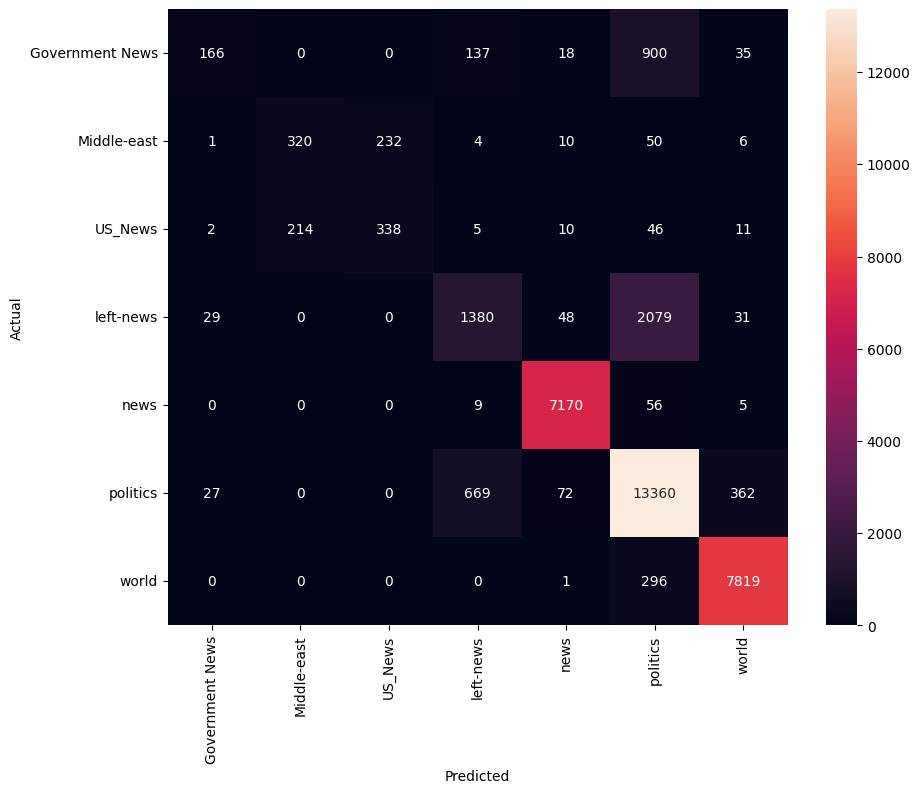

In [303]:

# Predict on the TRAINING set
y_train_pred = model_subject.predict(X_subject_train)

# Create the confusion matrix
cm = confusion_matrix(y_subject_train, y_train_pred)

# Plot it
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Here comes the problem, 
- The model is getting confused by the the term Government news and left-news and it is merging this with politics only.
- So, what needs to be done is merging the Government news and left-news with politics only and then training the model.

In [304]:
df_new = df

In [305]:
df['subject'].value_counts()

subject
politics           18113
world              10145
news                9050
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [306]:
df_new['subject'] = df_new['subject'].replace({
    'Government News': 'politics',
    'left-news': 'politics'})

In [307]:
df_new['subject'].value_counts()

subject
politics       24142
world          10145
news            9050
US_News          783
Middle-east      778
Name: count, dtype: int64

In [308]:
# again encoding
encoder = LabelEncoder()
df_new['subject_encoded'] = encoder.fit_transform(df_new['subject'])

In [309]:
df_new.head()

,title,text,subject,date,label,content,subject_encoded
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",news,"July 21, 2017",0,break gop chairman grassley enough demand trum...,2
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,news,"May 7, 2016",0,fail gop candid rememb hilari mock eulog video...,2
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,news,"December 3, 2016",0,mike penc new dc neighbor hilari troll homopho...,2
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politics,"October 6, 2017",1,california ag pledg defend birth control insur...,3
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,az rancher live us mexico border destroy nanci...,3


In [310]:
X_subject_2 = X_content
y_subject_2 = df_new['subject_encoded']

In [311]:
X_subject_2_train, X_subject_2_test, y_subject_2_train, y_subject_2_test = train_test_split(X_subject_2, y_subject_2, test_size=0.2, stratify=y_subject_2, random_state=42)

In [312]:
model_subject_2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [313]:
model_subject_2.fit(X_subject_2_train, y_subject_2_train)

/home/adii/Documents/PlatformIO/Projects/shieldX_helmet/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [314]:
X_subject_pred_2_train = model_subject_2.predict(X_subject_2_train)

In [315]:
accuracy_subject_2_train = accuracy_score(y_subject_2_train, X_subject_pred_2_train)

In [316]:
accuracy_subject_2_train

0.9582660504482432

In [317]:
X_subject_pred_2_test = model_subject_2.predict(X_subject_2_test)

In [318]:
accuracy_subject_2_test = accuracy_score(y_subject_2_test, X_subject_pred_2_test)

In [319]:
accuracy_subject_2_test

0.9249443207126948

#### Accuracy for subject identification ~ 92.5 %

## *Final accuracies :*
#### Fake v/s true
- accuracy ~ 98.7 %

#### Subject prediction :
- accuracy ~ 92.5 %


## 

In [320]:


# Save the models
joblib.dump(model_2, 'model_fake_detection.pkl')
joblib.dump(model_subject_2, 'model_subject_classification.pkl')

# Save the vectorizer and encoder
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(encoder, 'label_encoder.pkl')
joblib.dump(port_stem, 'porter_stemmer.pkl')

print("All models and preprocessors saved successfully!")

All models and preprocessors saved successfully!


### Now these things needs to be loaded in order to extract the model and convert it into an application
#### Fake v/s True :
- Fake v/s True - model_2.pkl

- The tfidf one that convert texts into numbers - vectorizer.pkl

- Port Stemmer - port_stem.pkl

#### Subject prediction :
- subject prediction model - model_subject_2.pkl

- The encoder, that added labels to it - encoder.pkl